In [199]:
import pandas as pd
data = pd.read_csv('dataset_diabetes/diabetic_data.csv')

Start cleaning.

In [166]:
"""Define functions for feature transformations"""

# converts label to binary, considered readmitted if patient was readmitted within 30 days
def label_convert_to_binary(label):
    if label == '<30' or label == '>30':
        return 1
    else:
        return 0

# 700 levels, convert to 1 of 9 categories
def diag_convert(label):
    try:
        label = float(label)
    except: # to address error could not convert string to float: 'V57'
        return "Other"
    if label == 785 or (label >= 390 and label <= 459):
        return "Circulatory"
    elif label == 786 or (label >= 460 and label <= 519):
        return "Respiratory"
    elif label == 787 or (label >= 520 and label <= 579):
        return "Digestive"
    elif str(label).startswith('250.'):
        return "Diabetes"
    elif label >= 800 and label <= 999:
        return "Injury"
    elif label >= 710 and label <= 739:
        return "Musculoskeletal"
    elif label == 788 or (label >= 580 and label <= 629):
        return "Genitourinary"
    elif (label >= 1 and label <= 239) or label == 780 or label == 781 or label == 784 or (label >= 790 and label <= 799) or (label >= 240 and label <= 279 and label != 250) or (label >= 680 and label <= 709) or label == 782 or (label >= 290 and label <= 319):
        return "Neoplasms"
    else:
        return "Other"

# bin age, going from 10 levels to 3
def age_convert(label):
    young_level = {'[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)'}
    mid_level = {'[50-60)', '[60-70)', '[70-80)'}
    old_level = {'[80-90)', '[90-100)'}
    if label in young_level:
        return 1
    elif label in mid_level:
        return 1.5
    elif label in old_level:
        return 2

# change from 8 levels to 2
# k = known, u = unknown
def admission_type_convert(label):
    known_level = {1,2,3,4,7}
    if label in known_level:
        return 'k'
    else:
        return 'u'

# go from 8 levels to 5
# r = referral, t = transfer, u = unknown, b = birth, o = other
def admission_source_convert(label):
    referral_level = {1,2,3}
    transfer_level = {4,5,6,10,18,22,25,26}
    unknown_level = {20,17,9}
    birth_level = {13,14,11}
    other_level = {8,7}
    if label in referral_level:
        return 'r'
    elif label in transfer_level:
        return 't'
    elif label in unknown_level:
        return 'u'
    elif label in birth_level:
        return 'b'
    elif label in other_level:
        return 'o'

# go from 25 levels to 6
# d = discharge, h = hospice, e = expired, u = unknown, o = other
def disposition_convert(label):
    discharge_level = {1,2,3,4,5,6,8,10,15,16,17,22,23,24,30,27,28,29}
    hospice_level = {13,14}
    expired_level = {11,19,20,21}
    unknown_level = {18,25,26}
    other_level = {7,9,12}
    if label in discharge_level:
        return 'd'
    elif label in hospice_level:
        return 'h'
    elif label in unknown_level:
        return 'u'
    elif label in expired_level:
        return 'e'
    elif label in other_level:
        return 'o'

In [200]:
"""Dedupe for patient encounters, selecting for encounter with maximum time_in_hospital"""
data = data.sort_values('time_in_hospital', ascending=False).drop_duplicates(subset=['patient_nbr'], keep='first')

"""Remove unnecessary features"""
data = data.drop(['encounter_id'], axis=1) # remove encounter ID, too unique and non-informative
data = data.drop(['weight', 'payer_code', 'medical_specialty', 'race'], axis=1) # these features have over 30% missing values
data = data.drop(['metformin-pioglitazone', 'glimepiride-pioglitazone', 'citoglipton', 'examide'], axis=1) # these all only have 1 unique value, 'No'
# optional: remove near zero variance features?
print(len(data.columns))

"""Perform transformations now"""
data['age'] = data['age'].apply(age_convert) # convert age to numeric bins: 1, 1.5, 2
data['diag_1'] = data['diag_1'].apply(diag_convert)
data['diag_2'] = data['diag_2'].apply(diag_convert)
data['diag_3'] = data['diag_3'].apply(diag_convert)
data['admission_source_id'] = data['admission_source_id'].apply(admission_source_convert)
data['admission_type_id'] = data['admission_type_id'].apply(admission_type_convert)
data['discharge_disposition_id'] = data['discharge_disposition_id'].apply(disposition_convert)

"""Drop rows where discharge disposition id is expired, as that doesn't help with readmission"""
indexNames = data[data['discharge_disposition_id'] == 'e'].index
data.drop(indexNames, inplace=True)

"""Remove patient nbr, was used for debugging purposes but now unnecessary"""
data = data.drop(['patient_nbr'], axis=1)

"""Drop gender == unknown, as that seems to show a massive error bar"""
indexNames = data[data['gender'] == 'Unknown/Invalid'].index
data.drop(indexNames, inplace=True)

# print(data.columns)
data['label'] = data['readmitted'].apply(label_convert_to_binary) # convert readmitted to binary classification label
data = data.drop(['readmitted'], axis=1) # we have the updated binary label, no need for duplicate label column

temp_cols=data.columns.tolist()
index=data.columns.get_loc("label")
new_cols=temp_cols[0:index] + temp_cols[index+1:] + temp_cols[index:index+1]
data=data[new_cols]
data.columns

41


Index(['gender', 'age', 'admission_type_id', 'discharge_disposition_id',
       'admission_source_id', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'metformin-rosiglitazone', 'change', 'diabetesMed', 'label'],
      dtype='object')

In [ ]:
"""One-hot encode categorical features. Note that if you're doing drug analysis, skip this step and work with original data"""
# prints out just the categorical variables
cat_data = data.select_dtypes(include = 'object')
categorical_columns = cat_data.columns
categorical_columns

# importing numpy
import numpy as np
# importing OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

enc = OneHotEncoder(handle_unknown='error')
enc.fit(cat_data)

# https://stackoverflow.com/questions/55229301/one-hot-encoding-multiple-columns-in-sklearn-and-naming-columns 
ohe_data = pd.get_dummies(data, columns = categorical_columns)
data = ohe_data

In [105]:
"""Convert the dataframe to numpy"""
np_data = data.to_numpy()
# np_data.shape

# isolate just the feature set
np_features = np_data[:, :-1]
# label column
np_label = np_data[:, -1]
# np_label

DBSCAN Clustering

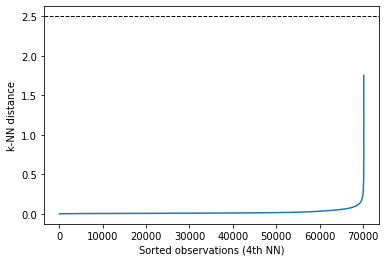

14


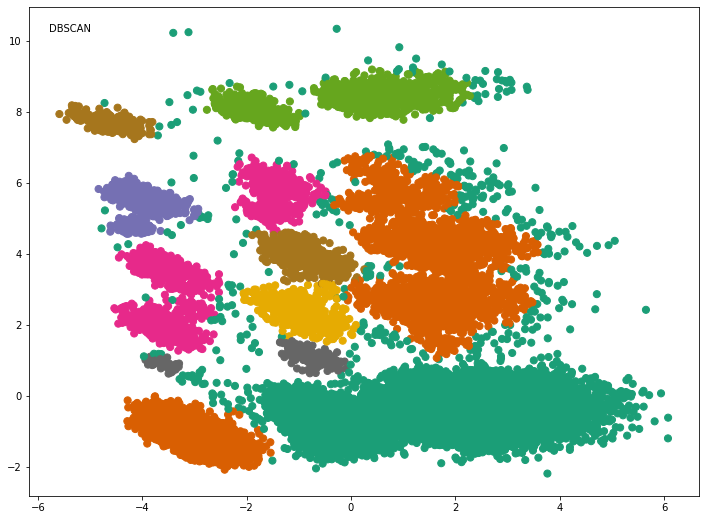

In [106]:
"""Let's try PCA"""
# first, you need to standardize data
# https://stackoverflow.com/questions/4544292/how-do-i-standardize-a-matrix
# only look at features
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

standardized_data = StandardScaler().fit_transform(np_features)
pca = PCA(n_components=2)
transformed_values = pca.fit_transform(standardized_data)

import numpy as np
from sklearn.neighbors import NearestNeighbors
# n_neighbors = 5 as kneighbors function returns distance of point to itself (i.e. first column will be zeros) 
nbrs = NearestNeighbors(n_neighbors=5).fit(transformed_values)
# Find the k-neighbors of a point
neigh_dist, neigh_ind = nbrs.kneighbors(transformed_values)
# sort the neighbor distances (lengths to points) in ascending order
# axis = 0 represents sort along first axis i.e. sort along row
sort_neigh_dist = np.sort(neigh_dist, axis=0)

import matplotlib.pyplot as plt
# use this plot to find the best eps
k_dist = sort_neigh_dist[:, 4]
plt.plot(k_dist)
plt.axhline(y=2.5, linewidth=1, linestyle='dashed', color='k')
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (4th NN)")
plt.show()

"""Let's try DBSCAN"""
# first standardize data
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from collections import Counter
clusters = DBSCAN(eps=0.25, min_samples=20, metric = 'euclidean').fit(transformed_values)
c = Counter(clusters.labels_)
num_clusters = len(c)
print(num_clusters)

y_pred = clusters.fit_predict(transformed_values)
plt.figure(figsize=(12,9))
plt.annotate('DBSCAN', xy=(0.03, 0.95), xycoords='axes fraction')
plt.scatter(transformed_values[:, 0], transformed_values[:, 1], c=y_pred, s=50, cmap='Dark2')
# green points are the outliers

In [154]:
def get_proportion(cluster):
    patients_indices = np.argwhere(clusters.labels_ == cluster)
    patients_indices.flatten()
    patients_indices.tolist()
    flat_list = [item for sublist in patients_indices for item in sublist]
    # print(flat_list) # list of indices
    # print(type(flat_list))
    patients = data.iloc[flat_list]
    # num_patients = len(patients)
    return patients
"""Get the percentages corresponding to each cluster"""
df_clusters = pd.DataFrame()
df_clusters['Cluster Number'] = None
df_clusters['Percent with 0 Label'] = None
df_clusters['Percent with 1 Label'] = None
zero_counts = []
one_counts = []
counts_list = []
for i in range(-1,13,1):
    patients = get_proportion(i)
    dist = dict(patients['label'].value_counts(normalize=True))
    # print(dist.keys())
    zero_counts.append(dist[0])
    one_counts.append(dist[1])
    # print(dist)
    counts = len(patients)
    counts_list.append(counts)
df_clusters['Cluster Number'] = [i for i in range(-1,13,1)]
df_clusters['Percent with 0 Label'] = zero_counts
df_clusters['Percent with 1 Label'] = one_counts
df_clusters['Number of Patients'] = counts_list
df_clusters

,Cluster Number,Percent with 0 Label,Percent with 1 Label,Number of Patients
0,-1,0.572650,0.427350,468
1,0,0.653261,0.346739,47318
2,1,0.731907,0.268093,14301
3,2,0.576349,0.423651,2613
4,3,0.563410,0.436590,481
5,4,0.633333,0.366667,1140
6,5,0.537415,0.462585,441
7,6,0.684795,0.315205,901
8,7,0.722110,0.277890,493
9,8,0.653465,0.346535,707


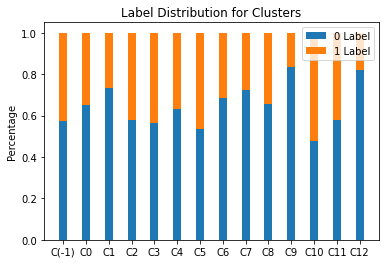

In [110]:
# make a stacked bar graph
import matplotlib.pyplot as plt
labels = ['C(-1)', 'C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12']
zeros_ = df_clusters['Percent with 0 Label']
ones_ = df_clusters['Percent with 1 Label']
width = 0.35
fix, ax = plt.subplots()
ax.bar(labels, zeros_, width, label='0 Label')
ax.bar(labels, ones_, width, bottom=zeros_, label='1 Label')
ax.set_ylabel('Percentage')
ax.set_title('Label Distribution for Clusters')
ax.legend()
plt.show()

In [111]:
data.isnull().values.sum() != 0

False

In [181]:
"""Now do some cluster analysis. Which features are most important in these clusters?"""
import sklearn
import interpret
from sklearn.model_selection import train_test_split
subset_data = get_proportion(10) # TODO: change data here
train_cols = subset_data.columns[0:-1]
label = subset_data.columns[-1]
X = subset_data[train_cols]
y = subset_data[label]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [182]:
from interpret.glassbox import ExplainableBoostingClassifier

ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)

# or substitute with LogisticRegression, DecisionTreeClassifier, RuleListClassifier, ...
# EBM supports pandas dataframes, numpy arrays, and handles "string" data natively.

ExplainableBoostingClassifier(feature_names=['age', 'time_in_hospital',
                                             'num_lab_procedures',
                                             'num_procedures',
                                             'num_medications',
                                             'number_outpatient',
                                             'number_emergency',
                                             'number_inpatient',
                                             'number_diagnoses',
                                             'gender_Female', 'gender_Male',
                                             'admission_type_id_k',
                                             'admission_type_id_u',
                                             'discharge_disposition_id_d',
                                             'discharge_disposition_id_h',
                                             'discharge_disp...
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'categorical',
                                             'categorical', 'categorical',
                                             'categorical', 'categorical',
                                             'categorical', 'categorical',
                                             'categorical', 'categorical',
                                             'categorical', 'categorical',
                                             'categorical', 'categorical',
                                             'categorical', 'categorical',
                                             'categorical', 'categorical',
                                             'categorical', 'categorical',
                                             'categorical', 'categorical', ...])

Create cohorts.

In [168]:
young_cohort = data[data['age'] == 1]
mid_cohort = data[data['age'] == 1.5]
old_cohort = data[data['age'] == 2]

print(len(young_cohort)) # 11227
print(len(mid_cohort)) # 45783
print(len(old_cohort)) # 13203

11227
45783
13203


Create drug treatment cohorts.

In [210]:
"""Drug combinations as features are: 
1. glyburide-metformin
2. glipizide-metformin
3. metformin-rosiglitazone

Individual drugs remaining are
1. metformin
2. repaglinide
3. nateglinide
4. chlorpropamide
5. glimepiride
6. acetohexamide
7. glipizide
8. glyburide
9. tolbutamide
10. pioglitazone
11. rosiglitazone
12. acarbose
13. miglitol
14. troglitazone
15. tolazamide
16. insulin
"""
drugs = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin']
drug_combination_dict = {}
for drug in drugs:
    # print(drug)
    other_drugs = drugs[:] # deep copy list
    other_drugs.remove(drug)
    for other in other_drugs:
        # print(other)
        intersection_name = drug + "-" + other
        intersection = data[(data[other] != 'No') & (data[drug] != 'No')]
        # print(len(intersection))
        drug_combination_dict[intersection_name] = len(intersection)
drug_combination_dict

{'metformin-repaglinide': 213,
 'metformin-nateglinide': 146,
 'metformin-chlorpropamide': 5,
 'metformin-glimepiride': 1061,
 'metformin-acetohexamide': 0,
 'metformin-glipizide': 2650,
 'metformin-glyburide': 2912,
 'metformin-tolbutamide': 0,
 'metformin-pioglitazone': 1564,
 'metformin-rosiglitazone': 1621,
 'metformin-acarbose': 57,
 'metformin-miglitol': 7,
 'metformin-troglitazone': 0,
 'metformin-tolazamide': 8,
 'metformin-insulin': 7488,
 'repaglinide-metformin': 213,
 'repaglinide-nateglinide': 5,
 'repaglinide-chlorpropamide': 0,
 'repaglinide-glimepiride': 42,
 'repaglinide-acetohexamide': 0,
 'repaglinide-glipizide': 65,
 'repaglinide-glyburide': 48,
 'repaglinide-tolbutamide': 0,
 'repaglinide-pioglitazone': 111,
 'repaglinide-rosiglitazone': 95,
 'repaglinide-acarbose': 11,
 'repaglinide-miglitol': 3,
 'repaglinide-troglitazone': 0,
 'repaglinide-tolazamide': 0,
 'repaglinide-insulin': 543,
 'nateglinide-metformin': 146,
 'nateglinide-repaglinide': 5,
 'nateglinide-chlo

In [211]:
with open('drug_combinations.txt', 'w') as f:
    for (k,v) in drug_combination_dict.items():
        f.write(k + ": " + str(v) + "\n")

In [216]:
list_tuples = []
for (k,v) in drug_combination_dict.items():
    drugs = k.split('-')
    new_tuple = tuple([drugs[0], drugs[1], v])
    if tuple([drugs[1], drugs[0], v]) in list_tuples: # exclude reverse pair
        continue
    else:
        list_tuples.append(new_tuple)
import csv
with open('drug_combinations.csv','w') as out:
    csv_out=csv.writer(out)
    csv_out.writerow(['source','target','weight'])
    for row in list_tuples:
        csv_out.writerow(row)

In [217]:
# get most populated cohorts
drug_combinations = pd.read_csv('drug_combinations.csv')
drug_combinations.sort_values(by=['weight'], ascending=False).head(10)

,source,target,weight
14,metformin,insulin,7488
83,glipizide,insulin,4505
91,glyburide,insulin,3312
6,metformin,glyburide,2912
104,pioglitazone,insulin,2895
5,metformin,glipizide,2650
109,rosiglitazone,insulin,2466
64,glimepiride,insulin,2046
9,metformin,rosiglitazone,1621
8,metformin,pioglitazone,1564


In [229]:
intersection_patients = []
for i in range(10):
    combination = drug_combinations.sort_values(by=['weight'], ascending=False).iloc[[i]]
    source = combination['source'].values[0]
    target = combination['target'].values[0]
    weight = combination['weight'].values[0]
    intersection = data[(data[source] != 'No') & (data[target] != 'No')]
    distribution = dict(intersection['label'].value_counts(normalize=True))
    intersection_patients.append(intersection)
    print(distribution)
# intersection = data[(data[other] != 'No') & (data[drug] != 'No')]

{0: 0.6733440170940171, 1: 0.3266559829059829}
{0: 0.6312985571587125, 1: 0.3687014428412875}
{0: 0.6533816425120773, 1: 0.3466183574879227}
{0: 0.6929945054945055, 1: 0.3070054945054945}
{0: 0.6317789291882556, 1: 0.3682210708117444}
{0: 0.6641509433962264, 1: 0.33584905660377357}
{0: 0.6289537712895377, 1: 0.3710462287104623}
{0: 0.6275659824046921, 1: 0.3724340175953079}
{0: 0.6650215916101172, 1: 0.3349784083898828}
{0: 0.6617647058823529, 1: 0.3382352941176471}


InterpretML

In [240]:
import interpret
import sklearn

# TODO: change the data here
from sklearn.model_selection import train_test_split
subset_data = data
train_cols = subset_data.columns[0:-1]
label = subset_data.columns[-1]
X = subset_data[train_cols]
y = subset_data[label]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

from interpret.glassbox import ExplainableBoostingClassifier

ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)

# or substitute with LogisticRegression, DecisionTreeClassifier, RuleListClassifier, ...
# EBM supports pandas dataframes, numpy arrays, and handles "string" data natively.

ExplainableBoostingClassifier(feature_names=['gender', 'age',
                                             'admission_type_id',
                                             'discharge_disposition_id',
                                             'admission_source_id',
                                             'time_in_hospital',
                                             'num_lab_procedures',
                                             'num_procedures',
                                             'num_medications',
                                             'number_outpatient',
                                             'number_emergency',
                                             'number_inpatient', 'diag_1',
                                             'diag_2', 'diag_3',
                                             'number_diagnoses',
                                             'max_glu_serum', 'A1Cresult',
                                             'metformin', 'r...
                                             'categorical', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'categorical', 'categorical',
                                             'categorical', 'continuous',
                                             'categorical', 'categorical',
                                             'categorical', 'categorical',
                                             'categorical', 'categorical',
                                             'categorical', 'categorical',
                                             'categorical', 'categorical',
                                             'categorical', 'categorical',
                                             'categorical', 'categorical', ...])

In [241]:
"""Get the top 10 most important features"""
ebm_features_dict = dict(zip(ebm.feature_names, ebm.feature_importances_))
ebm_features_dict_sorted = dict(sorted(ebm_features_dict.items(), key=lambda item: item[1], reverse=True))

import itertools 
# Initialize limit 
N = 10
    
# Using islice() + items() 
# Get first N items in dictionary 
out = dict(itertools.islice(ebm_features_dict_sorted.items(), N)) 

df_features = pd.DataFrame.from_dict(out, orient='index')
# printing result  
df_features.to_csv('original_feature_importances.csv')

In [116]:
# TODO: get ebm global explanations
from interpret import show
# shows importance of features and how each feature affects the model
ebm_global = ebm.explain_global()
y_pred = ebm.predict(X_test)
y_prob = ebm.predict_proba(X_test)
show(ebm_global)

<!-- http://127.0.0.1:7001/5255111312/ -->

In [242]:
"""Evaluate model performance - get metrics"""
# https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/ 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import numpy as np
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

# print(confusion_matrix(y_test,y_pred))
# print(classification_report(y_test,y_pred))
y_pred = ebm.predict(X_test)
y_prob = ebm.predict_proba(X_test)
print("Accuracy: " + str(accuracy_score(y_test, y_pred)))
print("AUROC: " + str(roc_auc_score(y_test, y_prob[:,1])))
precision, recall, thresholds = precision_recall_curve(y_test, y_prob[:,1])
print("AUPRC: " + str(auc(recall, precision)))

Accuracy: 0.6929782918303051
AUROC: 0.6928697059995539
AUPRC: 0.5293825863453268


In [252]:
"""Find common features between lists of most important features"""
feature_importance_list = ['cluster10_feature_importances.csv', 'cluster9_feature_importances.csv', 'drug_combinations_1_feature_importances.csv', 'drug_combinations_2_feature_importances.csv', 'drug_combinations_3_feature_importances.csv', 'mid_cohort_feature_importances.csv', 'old_cohort_feature_importances.csv', 'original_feature_importances.csv', 'young_cohort_feature_importances.csv']
features_weighted_dict = {}
def add_score(row):
    if row['feature'] in features_weighted_dict:
        features_weighted_dict[row['feature']] += row['score']
    else:
        features_weighted_dict[row['feature']] = row['score']
for file in feature_importance_list:
    df = pd.read_csv(file)
    df['feature'] = df['Unnamed: 0']
    df['score'] = df['0']
    df = df.drop('Unnamed: 0', axis=1)
    df = df.drop('0', axis=1)
    # print(df.columns)
    df.apply(add_score, axis=1)
    print(features_weighted_dict)
features_weighted_dict_sorted = dict(sorted(features_weighted_dict.items(), key=lambda item: item[1], reverse=True))
# features_weighted_dict_sorted

{'number_diagnoses': 0.1428457928077136, 'time_in_hospital': 0.1423032053722309, 'number_inpatient': 0.1166696095052895, 'num_lab_procedures': 0.1113394488634827, 'age': 0.0883824265229295, 'num_medications': 0.0813211932743775, 'num_procedures': 0.0679833650449344, 'metformin_No': 0.0665890471907042, 'metformin_Steady': 0.0659266506833998, 'diag_1_Circulatory': 0.06444880957599}
{'number_diagnoses': 0.1428457928077136, 'time_in_hospital': 0.1738024243068843, 'number_inpatient': 0.1166696095052895, 'num_lab_procedures': 0.1113394488634827, 'age': 0.0883824265229295, 'num_medications': 0.0813211932743775, 'num_procedures': 0.0679833650449344, 'metformin_No': 0.0665890471907042, 'metformin_Steady': 0.0659266506833998, 'diag_1_Circulatory': 0.06444880957599, 'number_outpatient x diag_2_Circulatory': 0.1095660070926296, 'time_in_hospital x num_lab_procedures': 0.1090162921056049, 'num_lab_procedures x num_procedures': 0.0609632134557172, 'num_lab_procedures x diag_2_Genitourinary': 0.05610

In [2]:
import pandas as pd
"""Find common features between lists of most important features"""
feature_importance_list = ['cluster10_feature_importances.csv', 'cluster9_feature_importances.csv', 'drug_combinations_1_feature_importances.csv', 'drug_combinations_2_feature_importances.csv', 'drug_combinations_3_feature_importances.csv', 'mid_cohort_feature_importances.csv', 'old_cohort_feature_importances.csv', 'original_feature_importances.csv', 'young_cohort_feature_importances.csv']
features_weighted_dict = {}
def add_score(row):
    if row['feature'] in features_weighted_dict:
        score = features_weighted_dict[row['feature']][0] + row['score']
        count = features_weighted_dict[row['feature']][1] + 1
        features_weighted_dict[row['feature']] = (score, count)
    else:
        tuple_info = (row['score'], 1)
        features_weighted_dict[row['feature']] = tuple_info
for file in feature_importance_list:
    df = pd.read_csv(file)
    df['feature'] = df['Unnamed: 0']
    df['score'] = df['0']
    df = df.drop('Unnamed: 0', axis=1)
    df = df.drop('0', axis=1)
    # print(df.columns)
    df.apply(add_score, axis=1)
features_weighted_dict_sorted = dict(sorted(features_weighted_dict.items(), key=lambda item: item[1][0], reverse=True))
features_weighted_dict_sorted

{'number_inpatient': (1.3119401929691843, 8),
 'time_in_hospital': (1.1910809835769902, 9),
 'number_diagnoses': (0.8791474777009549, 8),
 'num_medications': (0.5120433145787934, 7),
 'num_lab_procedures': (0.5090979365525369, 7),
 'number_outpatient': (0.44136746588425807, 7),
 'number_emergency': (0.2166964151361411, 4),
 'admission_source_id': (0.1811927040733897, 3),
 'num_procedures': (0.1599080549879539, 3),
 'age': (0.1505985046616255, 2),
 'number_outpatient x diag_2_Circulatory': (0.1095660070926296, 1),
 'diag_1_Circulatory': (0.1092958907273132, 2),
 'time_in_hospital x num_lab_procedures': (0.1090162921056049, 1),
 'admission_source_id_o': (0.1036787447541585, 2),
 'metformin': (0.10007333538437, 2),
 'diabetesMed_No': (0.08587286016135, 2),
 'diabetesMed': (0.0796002220312218, 1),
 'diag_1': (0.0763469514304874, 1),
 'discharge_disposition_id': (0.069169363666207, 1),
 'metformin_No': (0.0665890471907042, 1),
 'metformin_Steady': (0.0659266506833998, 1),
 'admission_source

In [17]:
cluster9_feat_importances = pd.read_csv('cluster9_feature_importances.csv')
cluster9_feat_importances = cluster9_feat_importances.set_axis(['Feature', 'Score'], axis='columns')
cluster9_feat_importances

,Feature,Score
0,number_outpatient x diag_2_Circulatory,0.109566
1,time_in_hospital x num_lab_procedures,0.109016
2,num_lab_procedures x num_procedures,0.060963
3,num_lab_procedures x diag_2_Genitourinary,0.056103
4,num_lab_procedures x num_medications,0.053261
5,num_lab_procedures x diag_1_Musculoskeletal,0.048515
6,time_in_hospital x number_inpatient,0.047687
7,num_medications x diag_2_Genitourinary,0.044070
8,time_in_hospital,0.031499
9,num_procedures x diag_2_Genitourinary,0.031293


In [14]:
featured_weighted_df = pd.DataFrame(features_weighted_dict_sorted)
featured_weighted_df = featured_weighted_df.T
featured_weighted_df = featured_weighted_df.set_axis(['Ensemble Score', 'Count'], axis='columns')
featured_weighted_df

,Ensemble Score,Count
number_inpatient,1.311940,8.0
time_in_hospital,1.191081,9.0
number_diagnoses,0.879147,8.0
num_medications,0.512043,7.0
num_lab_procedures,0.509098,7.0
number_outpatient,0.441367,7.0
number_emergency,0.216696,4.0
admission_source_id,0.181193,3.0
num_procedures,0.159908,3.0
age,0.150599,2.0
